In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] =150
plt.rcParams['font.size'] = 16


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


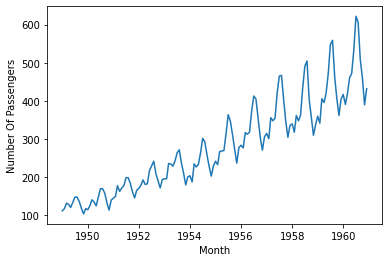

In [2]:
df=pd.read_csv('./DATA/AirPassengers.csv',index_col='Month', parse_dates=True)
df.info()
 #%% biểu đồ giá đóng cửa
plt.plot(df['#Passengers'])
plt.xlabel('Month')
plt.ylabel('Number Of Passengers')
plt.show()


In [5]:
print(df.isnull().values.any())

False


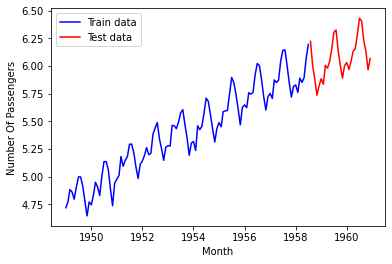

In [8]:
df_passengers=np.log(df['#Passengers'])
train_data,test_data=df_passengers[:int(len(df_passengers)*0.8)],df_passengers[int(len(df_passengers)*0.8):]
plt.plot(train_data,'blue',label='Train data')
plt.plot(test_data,'red',label='Test data')
plt.xlabel("Month")
plt.ylabel('Number Of Passengers')
plt.legend()
plt.show()


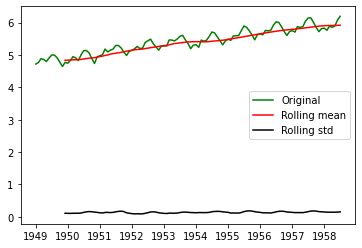

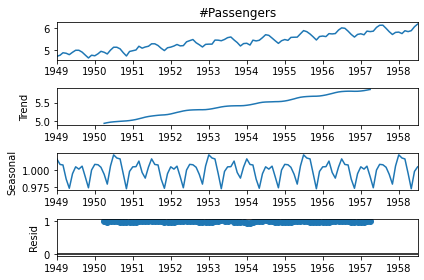

In [10]:

#Biểu đồ lịch sử so sánh số lượng hành khách với giá trị trung bình và độ lệch chuẩn : 12 kỳ trước
rolmean=train_data.rolling(12).mean()
rolstd=train_data.rolling(12).std()
plt.plot(train_data,'g',label='Original')
plt.plot(rolmean,'red',label='Rolling mean')
plt.plot(rolstd,'black',label='Rolling std')
plt.legend()
plt.show()
#Biểu đồ phân rã
decompose_results=seasonal_decompose(train_data,model='multiplicative', period=30)
decompose_results.plot()
plt.show()



In [11]:
test = adfuller(train_data, autolag='AIC')
def adf_test(data):
    indices = ['ADF: Test statistic', 'p value', '# of Lags', '# of Observations']
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[:4], index=indices)
    for key, value in test[4].items():
        results[f'Critical Value({key})'] = value
    return results

print(adf_test(train_data))

##Nhận xét: Gỉa thiết ADF Ho là chuỗi không dừng. '. Có trị tuyệt đối ADF=1.57  nhỏ hơn trị tuyệt đối của tất các giá trị trong ngưỡng --> Không bác bỏ giả thiết Ho
##Kết luận: Ho là chuỗi không dừng


ADF: Test statistic     -1.574027
p value                  0.496626
# of Lags               13.000000
# of Observations      101.000000
Critical Value(1%)      -3.496818
Critical Value(5%)      -2.890611
Critical Value(10%)     -2.582277
dtype: float64


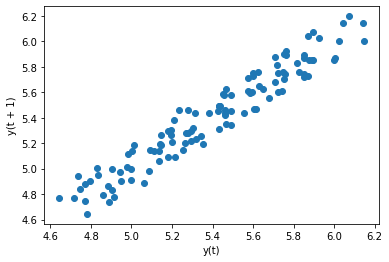

E:\PythonFinal\PYTHON-FINALPROJECT\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


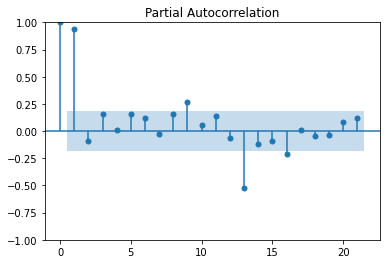

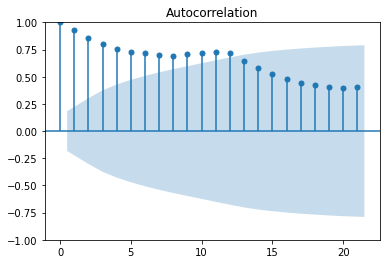

In [12]:
pd.plotting.lag_plot((train_data))
plt.show()
plot_pacf(train_data)
plt.show()
plot_acf(train_data)
plt.show()
## Nhận xét: Có sự tương quan cao

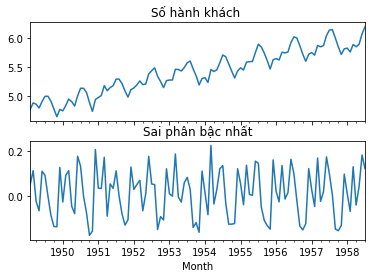

ADF: Test statistic     -2.635851
p value                  0.085812
# of Lags               12.000000
# of Observations      101.000000
Critical Value(1%)      -3.496818
Critical Value(5%)      -2.890611
Critical Value(10%)     -2.582277
dtype: float64


In [13]:
diff=train_data.diff(1).dropna()
#trực quan
fig,ax=plt.subplots(2,sharex='all')
train_data.plot(ax=ax[0],title='Số hành khách ')
diff.plot(ax=ax[1],title='Sai phân bậc nhất')
plt.show()
#kt lại
print(adf_test(diff))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-190.563, Time=5.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=109.117, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-185.104, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-20.552, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=717.162, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-191.591, Time=1.69 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-86.224, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-189.498, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-189.670, Time=0.77 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-140.808, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-187.659, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-188.333, Time=1.14 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 13.316 seconds
                              

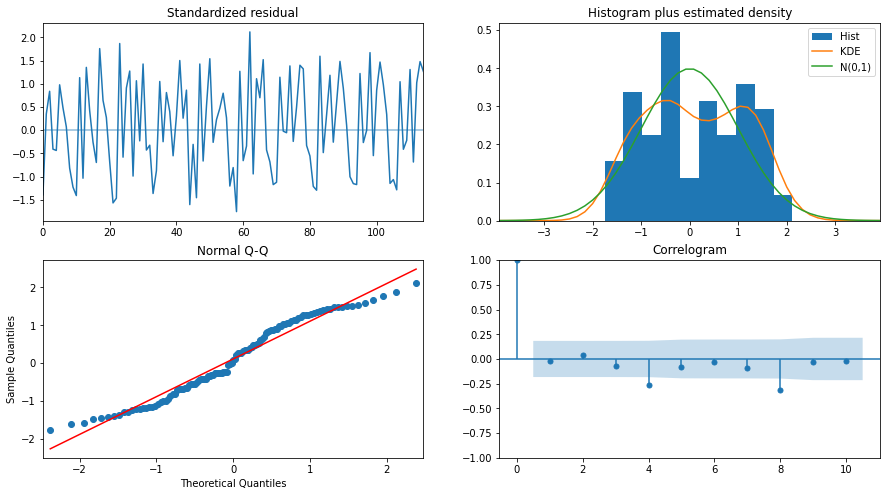

In [16]:
# Xác định q,d,p tự tương quan
stepwise_fit=auto_arima(train_data,trace=True,suppress_warnings=True,d=0)
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))
plt.show()



                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  99.480
Date:                Wed, 03 Aug 2022   AIC                           -188.961
Time:                        14:46:04   BIC                           -175.236
Sample:                    01-01-1949   HQIC                          -183.390
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0127      0.089      0.143      0.886      -0.161       0.186
ar.L1          0.9999      0.019     53.004      0.000       0.963       1.037
ma.L1          0.1612      0.093      1.725      0.0

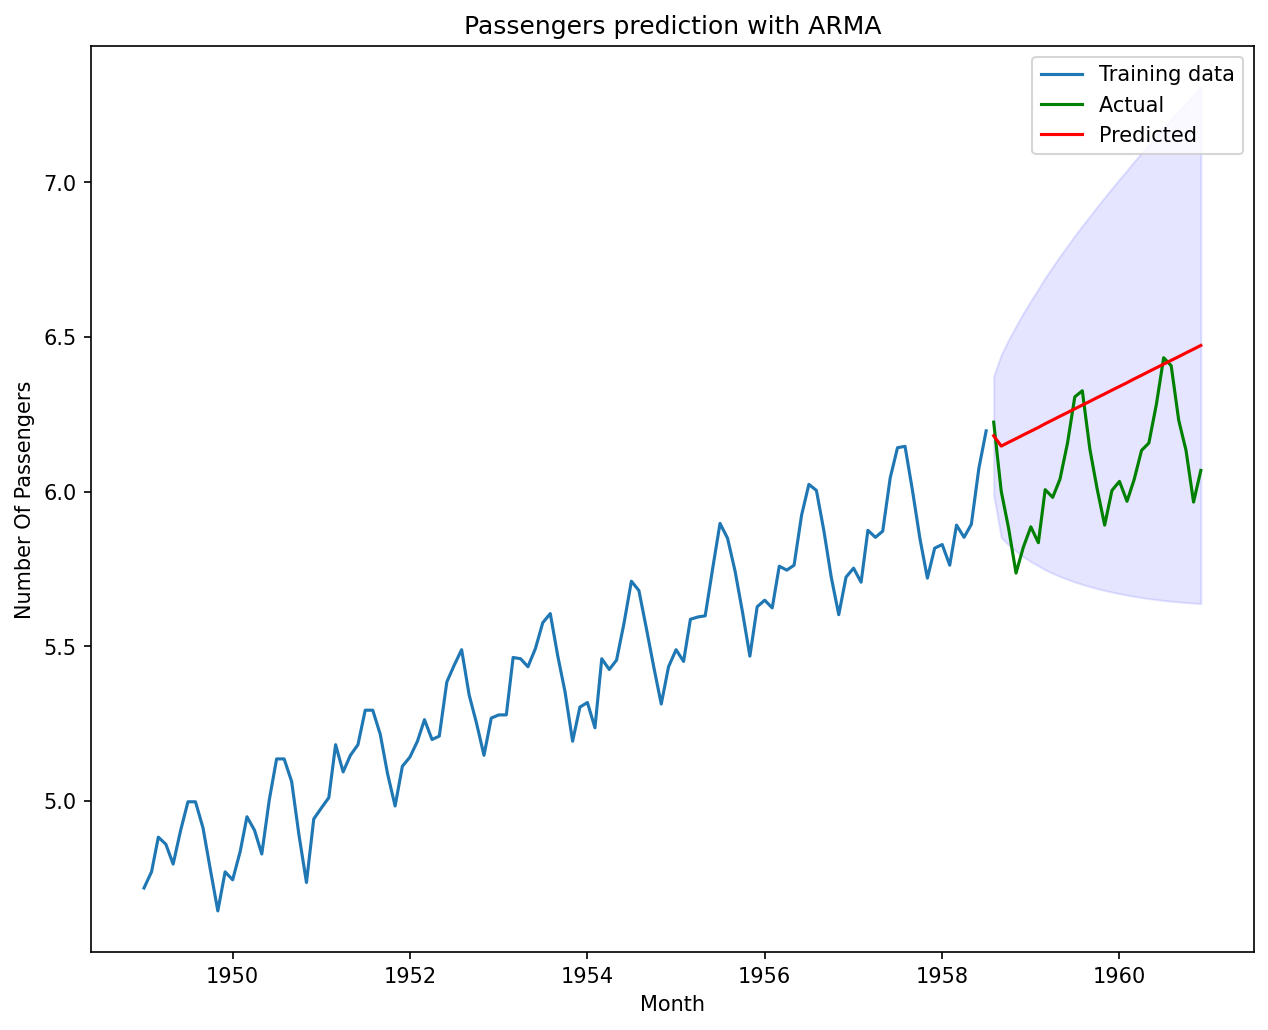

In [18]:
# Áp dụng mô hình ARMA
modelARMA=ARIMA(train_data,order=(1,0,2),trend='t')
fitted=modelARMA.fit()
print(fitted.summary())
# Dự báo
predsARMA = fitted.get_forecast(len(test_data), alpha=0.05)
fc = predsARMA.predicted_mean
fc.index = test_data.index
conf = predsARMA.conf_int(alpha=0.05)
conf = conf.to_numpy()
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10, 8), dpi=150)
plt.plot(train_data, label="Training data")
plt.plot(test_data, color="g", label="Actual ")
plt.plot(fc_series, color="r", label="Predicted ")
plt.fill_between(lower_series.index, lower_series, upper_series, color="b", alpha=.10)
plt.title('Passengers prediction with ARMA')
plt.xlabel("Month")
plt.ylabel("Number Of Passengers")
plt.legend()
plt.show()



                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  93.913
Date:                Wed, 03 Aug 2022   AIC                           -181.827
Time:                        14:49:17   BIC                           -173.592
Sample:                    01-01-1949   HQIC                          -178.484
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0141      0.074      0.190      0.849      -0.132       0.160
ar.L1          0.9998      0.016     60.897      0.000       0.968       1.032
sigma2         0.0107      0.002      5.070      0.0

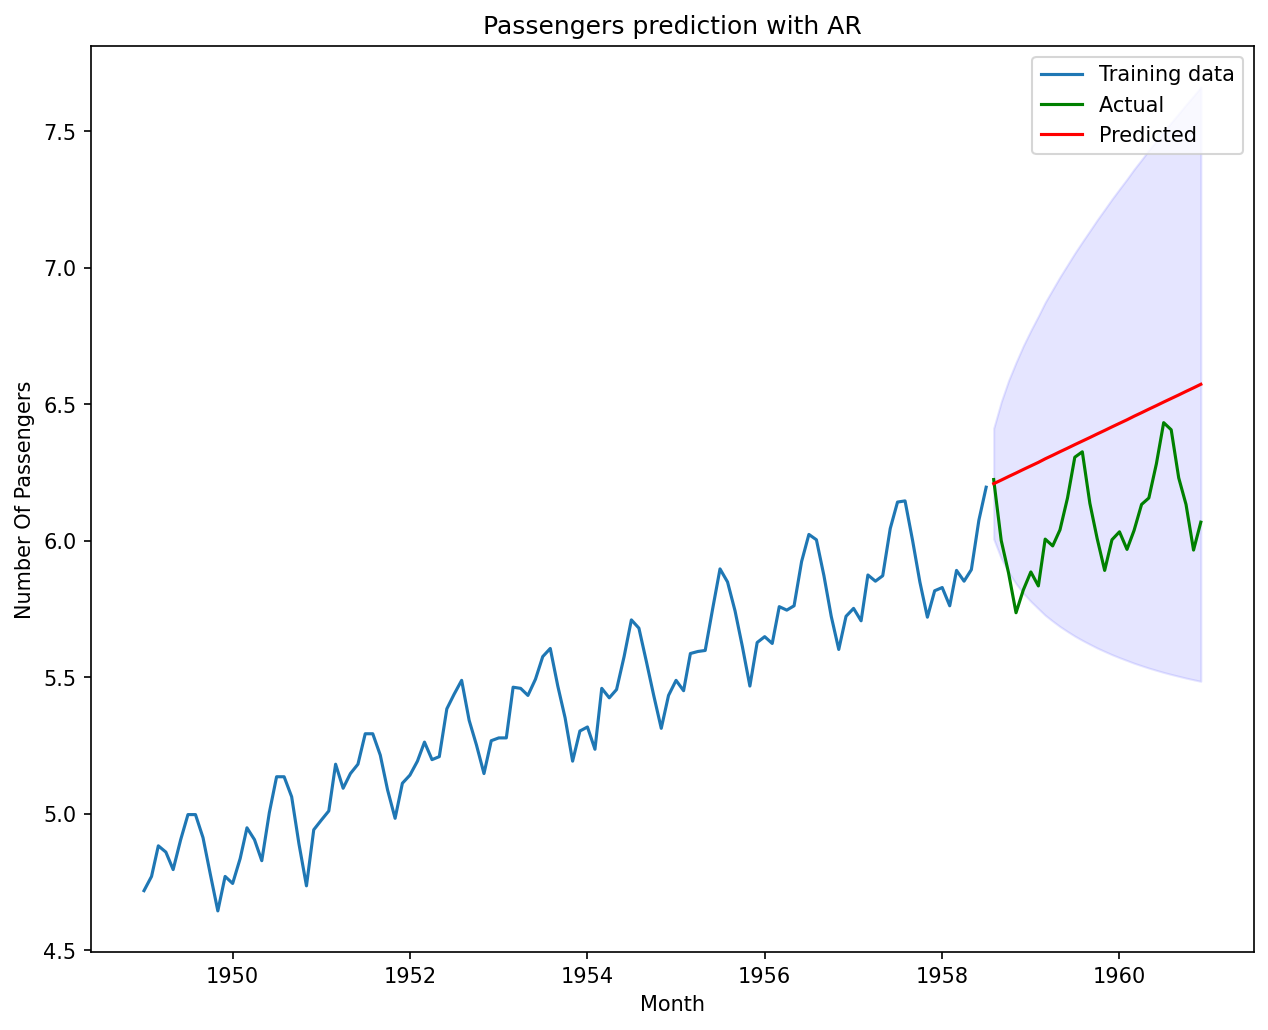

In [19]:
# Áp dụng mô hình AR
modelAR=ARIMA(train_data,order=(1,0,0),trend='t')
fitted=modelAR.fit()
print(fitted.summary())
# Dự báo
predsAR= fitted.get_forecast(len(test_data), alpha=0.05)
fc = predsAR.predicted_mean
fc.index = test_data.index
conf = predsAR.conf_int(alpha=0.05)
conf = conf.to_numpy()
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10, 8), dpi=150)
plt.plot(train_data, label="Training data")
plt.plot(test_data, color="g", label="Actual ")
plt.plot(fc_series, color="r", label="Predicted ")
plt.fill_between(lower_series.index, lower_series, upper_series, color="b", alpha=.10)
plt.title('Passengers prediction with AR')
plt.xlabel("Month")
plt.ylabel("Number Of Passengers")
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-212.316, Time=2.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189.733, Time=7.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-191.035, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-192.641, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.957, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-216.579, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-213.334, Time=0.78 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-217.979, Time=1.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-200.633, Time=1.10 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-220.038, Time=1.71 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-198.630, Time=0.54 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-214.417, Time=1.09 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=i

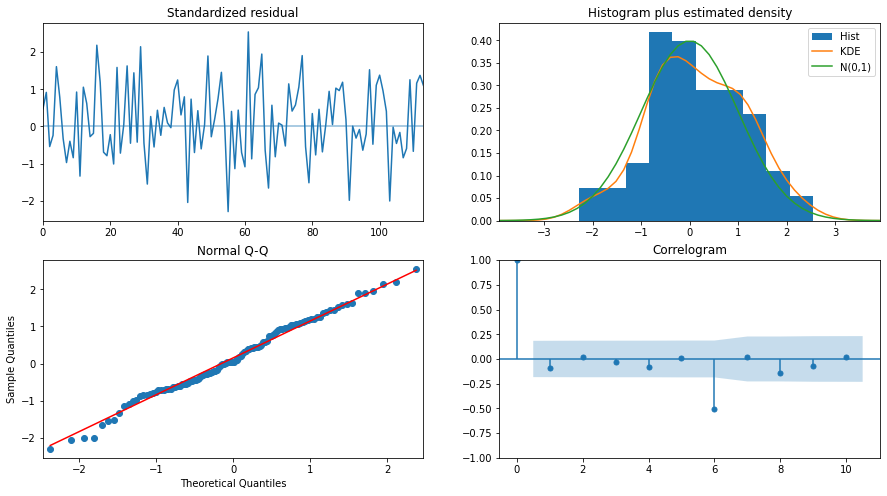

In [20]:
stepwise_fit_ARMIA=auto_arima(train_data,trace=True,suppress_warnings=True)
print(stepwise_fit_ARMIA.summary())
stepwise_fit_ARMIA.plot_diagnostics(figsize=(15,8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 118.889
Date:                Wed, 03 Aug 2022   AIC                           -219.777
Time:                        15:00:24   BIC                           -195.151
Sample:                    01-01-1949   HQIC                          -209.783
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0109      0.001     17.028      0.000       0.010       0.012
ar.L1         -0.0122      0.138     -0.088      0.930      -0.283       0.259
ar.L2          0.4207      0.127      3.311      0.0

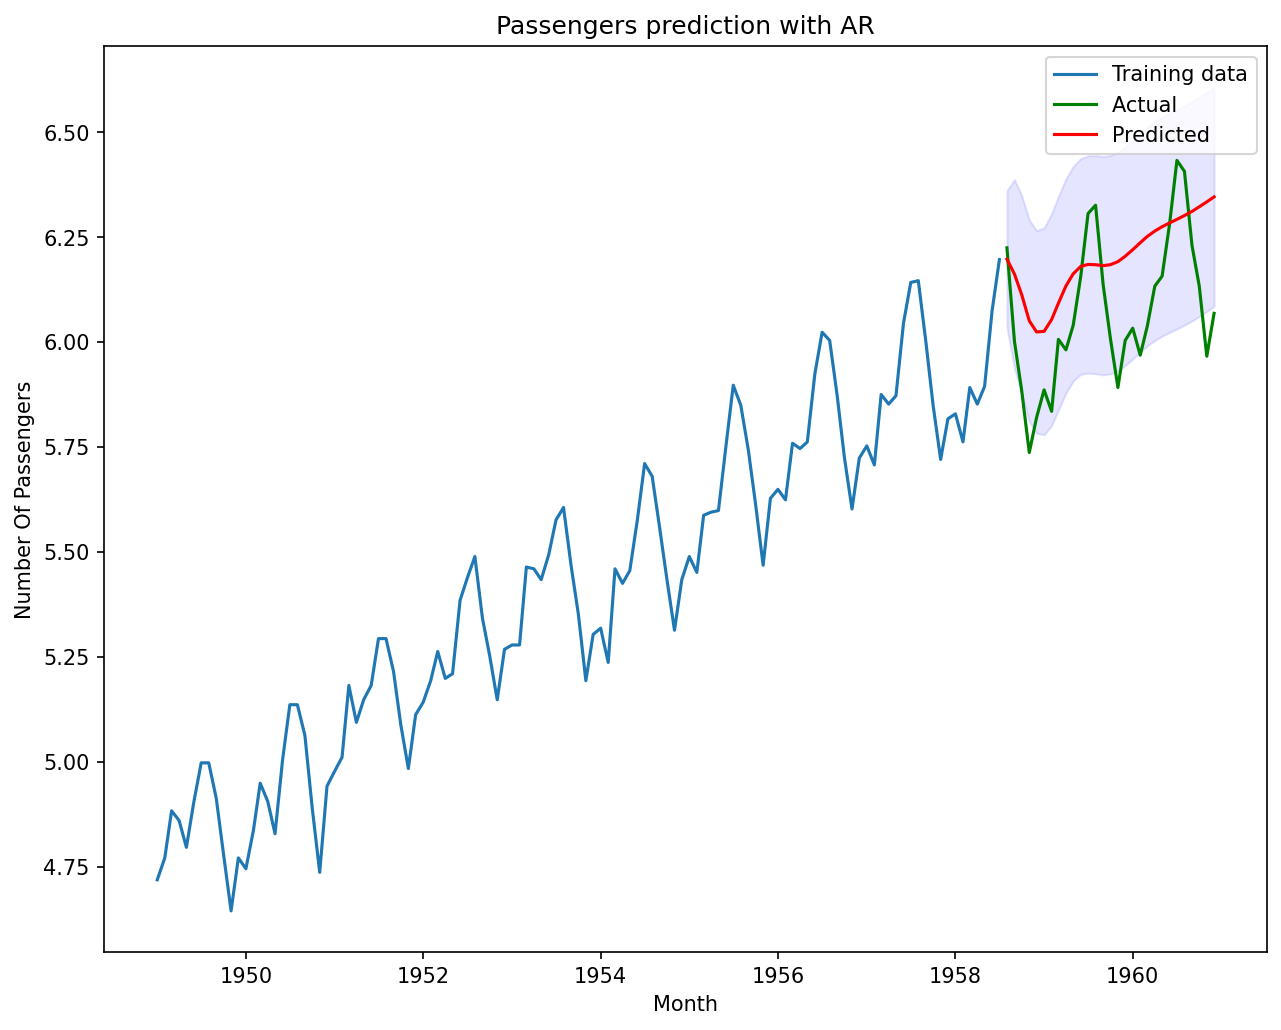

In [24]:
# Áp dụng mô hình

model_ARIMA=ARIMA(train_data,order=(5,1,2),trend='t')
fitted=model_ARIMA.fit()
print(fitted.summary())
# Dự báo
predsARIMA = fitted.get_forecast(len(test_data), alpha=0.05)
fc = predsARIMA.predicted_mean
fc.index = test_data.index
conf = predsARIMA.conf_int(alpha=0.05)
conf = conf.to_numpy()
fc_series=pd.Series(fc,index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,8),dpi=150)
plt.plot(train_data,label="Training data")
plt.plot(test_data,color="g",label="Actual ")
plt.plot(fc_series,color="r",label="Predicted ")
plt.fill_between(lower_series.index,lower_series,upper_series,color="b",alpha=.10)
plt.title('Passengers prediction with AR')
plt.xlabel("Month")
plt.ylabel("Number Of Passengers")
plt.legend()
plt.show()